# Lab 5

**In this tutroal, you will learn Multi-Dimensional Scaling and Isomap in section 1 and 2, respectively.**

## Section 1: Multi-Dimensional Scaling  

In this tutorial, you will learn the following

* What multi-dimensional scaling (MDS) is
* How we formulate the problem of MDS
* How we build a Euclidean distance matrix
* How we obtain the distance matrix in the reduced space
* How we generate a swiss roll dataset
* How we use MDS to do dimensionality reduction

### What is Multi-dimensional scaling (MDS)
MDS is an unsupervised dimensionality reduction algorithm, which can be either linear or non-linear depending on the distance matric we use. The motivation of MDS is to find a dataset in low dimensional space such that the pairwise distance between any two points in the space is close to the pairwise distance between the respective two points in original high dimensional space. It can be understood that if two data points are close in high dimensional space, they should be also close in reduced low dimensional space, and two dissimilar points in high dimensional space should be appearing far apart in reduced low dimensional space.

Mathematically, MDS is an optimisation problem that can be described as follows

$$\min_Y \|D^{(X)}-D^{(Y)}\|_2^2,$$

where $X=[\boldsymbol{x}_1, ..., \boldsymbol{x}_n] \in R^{d \times n}$ and $Y=[\boldsymbol{y}_1, ..., \boldsymbol{y}_n] \in R^{p \times n}$, where $p < d$ usually. In addition, $D^{(X)}$ is a pairwise distance matrix, given by 

$$D^{(X)} = \begin{bmatrix}
d_{11}^{(X)} & ... & d_{1n}^{(X)}\\ 
\vdots  & \ddots  & \vdots \\ 
d_{n1}^{(X)} & ... & d_{nn}^{(X)}
\end{bmatrix} $$

and 

$$D^{(Y)} = \begin{bmatrix}
d_{11}^{(Y)} & ... & d_{1n}^{(Y)}\\ 
\vdots  & \ddots  & \vdots \\ 
d_{n1}^{(Y)} & ... & d_{nn}^{(Y)}
\end{bmatrix} ,$$

where 
$d_{ij}^{(X)} = \|\boldsymbol{x}_i - \boldsymbol{x}_j\|$ denotes the Euclidean distance between $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$ and $d_{ij}^{(Y)} = \|\boldsymbol{y}_i - \boldsymbol{y}_j\|$ denotes the Euclidean distance between $\boldsymbol{y}_i$ and $\boldsymbol{y}_j$. As a result, the first optimisation problem can be rewritten as 

$$\min_Y \sum_{ij}\left(d_{ij}^{(X)} - d_{ij}^{(Y)}\right)^2,$$

which can be solved by the following four steps. Let's first load a new dataset (swiss roll) and visualise it.


In [1]:
from sklearn.datasets import make_s_curve
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

X, label = make_s_curve(n_samples = 500, random_state = 0)
X = X.T
print(X.shape)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


(3, 500)


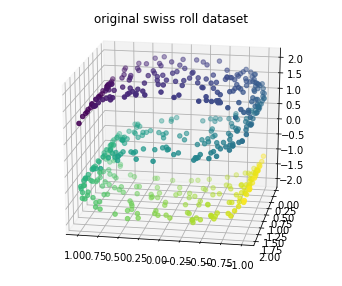

In [2]:
# plot original swiss roll data
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

plt.show()

### Four steps to do MDS
#### Step 1
We need to construct the distance matrix $D^{(X)}$ (ie. $d_{ij}^{(X)}$) of the given dataset $X \in R^{d \times n}$, which is given by

$$d_{ij}^{(X)} = \|\boldsymbol{x}_i-\boldsymbol{x}_j\|= \sqrt{(\boldsymbol x_i-\boldsymbol x_j)^T(\boldsymbol x_i-\boldsymbol x_j)}.$$

Let's compute $d_{ij}^{(X)}$ for the loaded dataset. 

In [3]:
def distance_matrix(X):
    dim,num = X.shape
    D = np.zeros([num,num],np.float32)
    for i in range(num):
        for j in range(num):
            D[i,j] = np.dot((X[:,i]-X[:,j]).T,(X[:,i]-X[:,j]))**0.5
    return D

In [4]:
D = distance_matrix(X)
print("The shape of the constructed distance matrix is %dx%d"%(D.shape))

The shape of the constructed distance matrix is 500x500


#### Step 2

We need to create a centering matrix $H \in R^{n\times n}$
$$H = I-\frac{1}{n}\boldsymbol{e}\boldsymbol{e}^{T},$$
where $\boldsymbol{e}=[1,1,\cdots,1]^{T}\in \mathbb{R}^{n\times 1}$. Then, construct a double centered matrix K, which reads
$$ K = -\frac{1}{2}HDH.$$

In [5]:
def H_matrix(size):
    e = np.ones((size,1),np.float32)
    I = np.identity(size) 
    H = I - (1.0/size)*np.dot(e, e.T) 
    return H

In [6]:
H = H_matrix(D.shape[0])
K = -0.5*np.dot(np.dot(H,D**2),H)

#### Step 3

Determine the $p$ largest eigenvalues ${\Lambda_1,...,\Lambda_p}$ and correponding $p$ eigenvectors ${V_1,...,V_p}$ of $K$ defined in Step 2. 

In [7]:
p = 3

# def select_top_p_eignvalues
eig_val, eig_vec = np.linalg.eig(K)

eig_val_ind = np.argsort(eig_val)
eig_val_ind = eig_val_ind[::-1]
eig_val_ind = eig_val_ind[0:p]

eig_val_p = eig_val[eig_val_ind]
V_p = eig_vec[:,eig_val_ind]

* `np.linalg.eig`: a function that computes all eigenvectors and eigenvalues
* `np.argsort`: a sort function that returns the index of the ranked array (from min to max)

#### Step 4

Finally, applying the equation

$$Y= \Lambda_p^{\frac{1}{2}} V_p^T$$

to reduce the dimensionality of original dataset. 

* $V_p$: consists of top-p eigenvectors 
* $\Lambda_p$: is a diagonal matrix whose diagonal entries are of the top-p eigenvalues

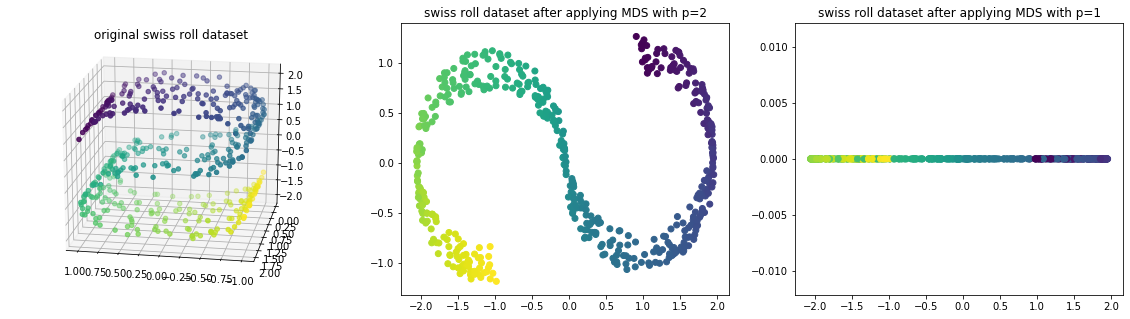

In [8]:
sigma_p = np.diag(eig_val_p**0.5)
Y = np.dot(sigma_p, V_p.T)

# plot data before and after dimenional reduction
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(Y[0, :], Y[1, :], c = label)
ax2.set_title("swiss roll dataset after applying MDS with p=2")

y_axis = np.zeros(500)
ax3 = fig.add_subplot(133)
ax3.scatter(Y[0, :], y_axis, c = label)
ax3.set_title("swiss roll dataset after applying MDS with p=1")

plt.show()

Then we show the data with reduced dimension in 2D space (second figure) and in 1D space (third figure). As you can see, in the third figure, the projected data got messed up. One final note here is if you apply PCA to the first figure you will get the same outputs as shown in the second and third figures. This is due to the fact that PCA is equivalent to MDS if we use the Euclidean distance as our distance matric. We will see examples in next session how the use of different distance matrices (eg. geodesic distance) will impact dimenionality reduction results. 

## Section 2:  Isomap

In this tutorial, you will learn the following

* What Isomap is
* How we implement Isomap
* What a K-nearest neighbor graph is
* How we compute a geodesic distance matrix
* How we use Isomap to visualise a nonlinear data set


### What is Isomap

Isomap is an unsupervised non-linear dimensionality reduction method, and it is one of most popular manifold learning algorithms. In the concept of manifold learning, we usually assume high-dimensional data has a low-dimensional intrinsic structure. Therefore, Tenenbaum (the inventor of Isomap) proposed a "global geometric framework for nonlinear dimensionality reduction" to compute the global optimal solution and ensure this solution represents the true structure of the original high-dimensional data in the low-dimensional space. 

Recall in MDS we need to construct the Euclidean distance matrix $D$ of a given dataset $X \in R^{d \times n}$, which is given by

$$D_{ij} = \|\boldsymbol{x}_i-\boldsymbol{x}_j\|= \sqrt{(\boldsymbol x_i-\boldsymbol x_j)^T(\boldsymbol x_i-\boldsymbol x_j)}.$$

Then, we need to compute $K$ with the Euclidean distance matrix $D$

$$ K = -\frac{1}{2}HDH.$$

Next, we do eigen-decomposition on $K$ to find the top-p eigenvectors $V_p$ and eigenvectors $\Lambda_p$ to reduce dimensions of data $X$ from $d$ to $p$, resulting in $Y \in R^{p\times n}$

$$Y= \Lambda_p^{\frac{1}{2}} V_p^T.$$


Isomap is very similar to MDS in terms of their formulations. The only difference is we compute the geodesic distance matrix $D^{(G)}$ (from data $X$) in Isomap instead of the Euclidean distance $D$ used in MDS. Computing geodesic distance will need us to construct a graph which we use K-nearest neighbour graph in this tutorial. Lets walk though the process in detail. First, we need to load data. Again here we use the swiss roll dataset provided by `sklearn`.

In [1]:
from sklearn.datasets import make_s_curve
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

X, label = make_s_curve(n_samples = 500, random_state = 0)
X = X.T
print(X.shape)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


(3, 500)


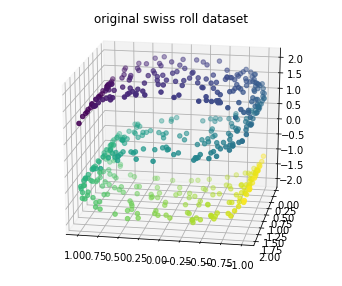

In [2]:
# plot original swiss roll data
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

plt.show()

The idea of Isomap is first to construct a K nearest graph and then compute the geodesic distance. To do these, we can use two built-in functions provided by python `sklearn`: `kneighbors_graph` and `graph_shortest_path`.

In [16]:
from sklearn.neighbors import kneighbors_graph
from sklearn.utils.graph import graph_shortest_path

What the `geodesic_distance_dijkstra` function does is to take original data $X$ and the number of K nearest points (a hyperparameter) as inputs. Then use `kneighbors_graph` to compute a K nearest neighbour graph `kng`, which is then passed to `graph_shortest_path` to compute geodesic distance `D_G` using the Dijkstra algorithm. 

In [17]:
def geodesic_distance_dijkstra(X, num_k_points = 15):
   
    kng = kneighbors_graph(X.T, num_k_points, mode='distance')
    D_G = graph_shortest_path(kng, method='D', directed=False)
    
    return kng, D_G

The following `top_p_eigen_vectors_values` function is to top-p eigenvectors and eigenvalues, which is mostly same as that used in PCA. However, note that due to the fact geodesic distance is guaranteed to be positive semi-definite matrix, eigenvalues of $K= -\frac{1}{2}HD^{(G)}H$ may be smaller than zeros. Therefore, we use `np.abs` here to make sure all eigenvalues larger than zeros. 

In [18]:
def top_p_eigen_vectors_values(eig_val, eig_vec, p):

    eig_val = np.abs(eig_val)
    eig_val_ind = np.argsort(eig_val)
    eig_val_ind = eig_val_ind[::-1]
    eig_val_ind = eig_val_ind[0:p]
    
    eig_val_p = eig_val[eig_val_ind]
    V_p = eig_vec[:,eig_val_ind]
    
    return V_p, eig_val_p

The `H_matrix` function is used to centralise the geodesic distance $D^{(G)}$.

In [19]:
def H_matrix(size):
    e = np.ones((size,1),np.float32)
    I = np.identity(size) 
    H = I - (1.0/size)*np.dot(e, e.T) 
    return H

We can first visualise what a K neareset neighbour graph looks like in the following code. 

Text(0.5, 0.92, '20-nearest neighbour graph built on all 500 points')

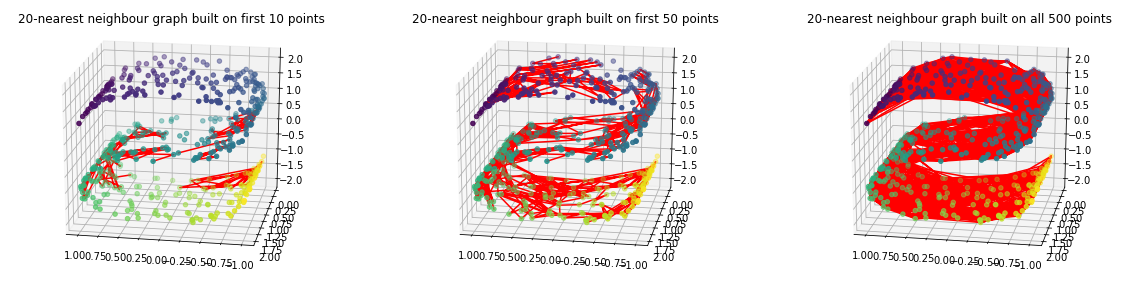

In [20]:
num_k_points = 20
kng, _ = geodesic_distance_dijkstra(X, num_k_points)
ind_asc = np.argsort(kng.toarray(), axis = 1)
knn_ind = ind_asc[:, -num_k_points:]

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
for i in range(10):
    ax1.plot(X[0, knn_ind[i,:]], X[1, knn_ind[i,:]], X[2, knn_ind[i,:]], c='r')
ax1.view_init(20, 100)
ax1.set_title("20-nearest neighbour graph built on first 10 points")

ax2 = fig.add_subplot(1, 3, 2 , projection='3d')
ax2.scatter(X[0,:], X[1,:], X[2,:], c = label)
for i in range(50):
    ax2.plot(X[0, knn_ind[i,:]], X[1, knn_ind[i,:]], X[2, knn_ind[i,:]], c='r')
ax2.view_init(20, 100)
ax2.set_title("20-nearest neighbour graph built on first 50 points")

ax3 = fig.add_subplot(1, 3, 3 , projection='3d')
ax3.scatter(X[0,:], X[1,:], X[2,:], c = label)
for i in range(500):
    ax3.plot(X[0, knn_ind[i,:]], X[1, knn_ind[i,:]], X[2, knn_ind[i,:]], c='r')
ax3.view_init(20, 100)
ax3.set_title("20-nearest neighbour graph built on all 500 points")

Finally, we need to put together all pieces of code together to reduce the dimension of $X$. The idea is to compute the geodesic distance $D_G$ using `geodesic_distance_dijkstra` using data $X$ and pre-defined `num_k_points`. Then construct $K= -\frac{1}{2}HD^{(G)}H$ and perform eigen-decomposition on $K$ using `np.linalg.eig`. Then pick up the top-p eigenvalues and eigenvectors using `top_p_eigen_vectors_values`. Finally, use $Y= \Lambda_p^{\frac{1}{2}} V_p^T.$ to reduce the data dimension. 


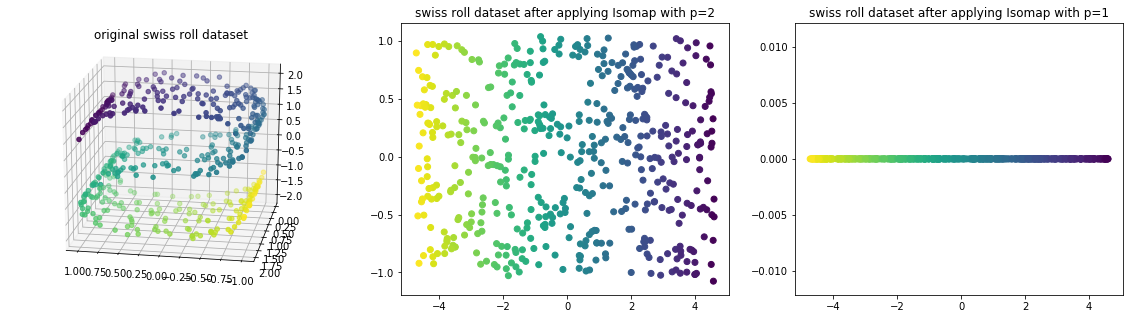

In [21]:
_, D_G = geodesic_distance_dijkstra(X, num_k_points)

H = H_matrix(X.shape[1])
K = -0.5*np.dot(np.dot(H,D_G**2),H)

eig_val, eig_vec = np.linalg.eig(K)
V_p, eig_val_p = top_p_eigen_vectors_values(eig_val, eig_vec, 2)
sigma_p = np.diag(eig_val_p**0.5)
Y = np.dot(sigma_p, V_p.T)

# plot data before and after dimenional reduction
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(Y[0, :], Y[1, :], c = label)
ax2.set_title("swiss roll dataset after applying Isomap with p=2")

y_axis = np.zeros(500)
ax3 = fig.add_subplot(133)
ax3.scatter(Y[0, :], y_axis, c = label)
ax3.set_title("swiss roll dataset after applying Isomap with p=1")

plt.show()

As can been seen from these figures, Isomap has successfully unfolded the swiss roll data to the low-dimensional spaces. In figure 2, we can see the data points after projection (unfolding) are not messed up. The same observation applies to the third image, where data points are projected to a 1D line. If we compare the method with MDS using the Euclidea distance, there is a clear improvement, as Isomap (MDS with geodesic distance) has the capability of handling nonlinear datasets while linear methods such as PCA (ie. MDS using the Euclidea distance) are unable to do so. 

In [22]:
def euclidean_distance(X):
    _, num = X.shape
    D_E = np.zeros([num,num],np.float32)
    for i in range(num):
        for j in range(num):
            D_E[i,j] = np.dot((X[:,i]-X[:,j]).T,(X[:,i]-X[:,j]))**0.5
    return D_E

Another method to compute a geodesic distance is using Floyd–Warshall algorithm [check here](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm). The algorithm requires to compute the Euclidean matrix $D$ from data $X$ first and also needs a pre-defined parameter (ie. the number of K nearest neighbour points). Try your best to write the algorithm below.

In [23]:
def geodesic_distance_floyd(X, num_k_points = 15):
    
    D_E = euclidean_distance(X)
    
    _, num = X.shape
    D_G = np.ones([num,num],np.float32)*np.inf
    D_ind = np.argsort(D_E, axis=1)
    for i in range(num):
        D_G[i, D_ind[i, 0:num_k_points+1]] = D_E[i, D_ind[i, 0:num_k_points+1]]
        
    for k in range(num):
        for i in range(num):
            for j in range(num):
                if D_G[i,k] + D_G[k,j] < D_G[i,j]:
                    D_G[i,j] = D_G[i,k] + D_G[k,j]
    return D_G

Finally, we need to put together all pieces of code together to reduce the dimension of $X$. First compute the geodesic distance $D_G$ using `geodesic_distance_floyd` using data $X$ and pre-defined `num_k_points`. Then construct $K= -\frac{1}{2}HD^{(G)}H$ and perform eigen-decomposition on $K$ using `np.linalg.eig`. Then pick up the top-p eigenvalues and eigenvectors using `top_p_eigen_vectors_values`. Finally, use $Y= \Lambda_p^{\frac{1}{2}} V_p^T$ to reduce the data dimension. 

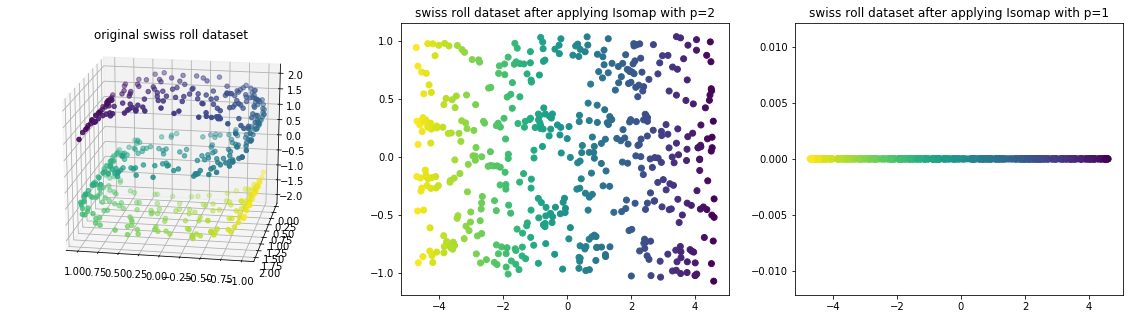

In [25]:
num_k_points = 20
D_G = geodesic_distance_floyd(X, num_k_points)

H = H_matrix(X.shape[1])
K = -0.5*np.dot(np.dot(H,D_G**2),H)

eig_val, eig_vec = np.linalg.eig(K)
V_p, eig_val_p = top_p_eigen_vectors_values(eig_val, eig_vec, 2)
sigma_p = np.diag(eig_val_p**0.5)
Y = np.dot(sigma_p, V_p.T)

# plot data before and after dimenional reduction
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(Y[0, :], Y[1, :], c = label)
ax2.set_title("swiss roll dataset after applying Isomap with p=2")

y_axis = np.zeros(500)
ax3 = fig.add_subplot(133)
ax3.scatter(Y[0, :], y_axis, c = label)
ax3.set_title("swiss roll dataset after applying Isomap with p=1")

plt.show()
